## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from tensorflow_probability import edward2 as ed
%matplotlib inline

/Users/andresmasegosa/Google Drive/papers/2019-denmark-pac-bayes/tfp0.7/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/andresmasegosa/Google Drive/papers/2019-denmark-pac-bayes/tfp0.7/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/andresmasegosa/Google Drive/papers/2019-denmark-pac-bayes/tfp0.7/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) 

/Users/andresmasegosa/Google Drive/papers/2019-denmark-pac-bayes/tfp0.7/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/andresmasegosa/Google Drive/papers/2019-denmark-pac-bayes/tfp0.7/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/andresmasegosa/Google Drive/papers/2019-denmark-pac-bayes/tfp0.7/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be unders

# Configuration

Now we define the learning method and whether there will be or not model miss-specification. 



In [2]:
## Learning Method
# 0. MAP Inference 
# 1. Variational Inference
# 2. PAC2-Varitional Inference, $\rho(\theta|D)
# 3. PAC2-Varitional Inference, $\rho_h(\theta|D)

LEARNING_METHOD = 3

## Control the presence of model miss-specficication as shown in Figures 2 and 3. 
MODEL_MISSSPECIFICATION = True



# Data Set

In this first part, we present the data set used for this example. By setting the flag ``MODEL_MISSSPECIFICATION`` we can generate the figures under perfect model specification or under model miss-specification. 

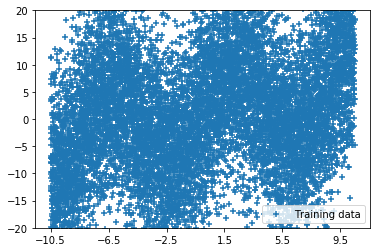

In [3]:
# Set seeds for reproducibility
np.random.seed(0)
tf.set_random_seed(0)

if MODEL_MISSSPECIFICATION:
    VAR=10.
else:
    VAR=1.

NSAMPLE = 10000
def sampleData(samples, variance):
    x = np.linspace(-10.5, 10.5, samples).reshape(-1, 1)
    r = 1+np.float32(np.random.normal(size=(samples,1),scale=variance))
    y = np.float32(np.sin(0.75*x)*7.0+x*0.5+r*1.0)
    return (x,y)

(x_train, y_train) = sampleData(NSAMPLE, VAR)
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.ylim(-20,20)
plt.xticks(np.arange(-10.5, 10.5, 4))
plt.legend()
plt.show()

# Learning a Neural Network

We now employ Tensorflow Probability and Edward 2 to define and make varitional inference over a Bayesian neural network. 

In [4]:
NHIDDEN = 20

def model(NHIDDEN, NSAMPLE):
    W = ed.Normal(loc=tf.zeros([1, NHIDDEN]), scale=1., name="W")
    b = ed.Normal(loc=tf.zeros([1, NHIDDEN]), scale=1., name="b")

    W_out = ed.Normal(loc=tf.zeros([NHIDDEN, 1]), scale=1., name="W_out")
    b_out = ed.Normal(loc=tf.zeros([1, 1]), scale=1., name="b_out")

    x = ed.Normal(loc=tf.zeros([NSAMPLE, 1]), scale=1.0, name="x")
    hidden_layer = tf.nn.tanh(tf.matmul(x, W) + b)
    out = tf.matmul(hidden_layer, W_out) + b_out
    y = ed.Normal(loc=out, scale=1.0, name="y")

    return W, b, W_out, b_out, x, y


def qmodel(NHIDDEN):
    W_loc = tf.Variable(tf.random_normal([1, NHIDDEN], 0.0, 0.05, dtype=tf.float32))
    b_loc = tf.Variable(tf.random_normal([1, NHIDDEN], 0.0, 0.05, dtype=tf.float32))

    if LEARNING_METHOD==0:
        W_scale = 0.000001
        b_scale = 0.000001
    else:
        W_scale = tf.nn.softplus(tf.Variable(tf.random_normal([1, NHIDDEN], -10., stddev=0.05, dtype=tf.float32)))
        b_scale = tf.nn.softplus(tf.Variable(tf.random_normal([1, NHIDDEN], -10., stddev=0.05, dtype=tf.float32)))

    qW = ed.Normal(W_loc, scale=W_scale, name="W")
    qW_ = ed.Normal(W_loc, scale=W_scale, name="W")

    qb = ed.Normal(b_loc, scale=b_scale, name="b")
    qb_ = ed.Normal(b_loc, scale=b_scale, name="b")

    W_out_loc = tf.Variable(tf.random_normal([NHIDDEN, 1], 0.0, 0.05, dtype=tf.float32))
    b_out_loc = tf.Variable(tf.random_normal([1, 1], 0.0, 0.05, dtype=tf.float32))
    if LEARNING_METHOD==0:
        W_out_scale = 0.000001
        b_out_scale = 0.000001
    else:
        W_out_scale = tf.nn.softplus(tf.Variable(tf.random_normal([NHIDDEN, 1], -10., stddev=0.05, dtype=tf.float32)))
        b_out_scale = tf.nn.softplus(tf.Variable(tf.random_normal([1, 1], -10., stddev=0.05, dtype=tf.float32)))

    qW_out = ed.Normal(W_out_loc, scale=W_out_scale, name="W_out")
    qb_out = ed.Normal(b_out_loc, scale=b_out_scale, name="b_out")

    qW_out_ = ed.Normal(W_out_loc, scale=W_out_scale, name="W_out")
    qb_out_ = ed.Normal(b_out_loc, scale=b_out_scale, name="b_out")

    return qW, qW_, qb, qb_, qW_out, qW_out_, qb_out, qb_out_


W,b,W_out,b_out,x,y = model(NHIDDEN,NSAMPLE)

qW,qW_,qb,qb_,qW_out,qW_out_,qb_out,qb_out_ = qmodel(NHIDDEN)

with ed.interception(ed.make_value_setter(W=qW,b=qb,W_out=qW_out,b_out=qb_out,x=x_train,y=y_train)):
    pW,pb,pW_out,pb_out,px,py = model(NHIDDEN,NSAMPLE)

with ed.interception(ed.make_value_setter(W=qW_,b=qb_,W_out=qW_out_,b_out=qb_out_,x=x_train,y=y_train)):
    pW_,pb_,pW_out_,pb_out_,px_,py_ = model(NHIDDEN,NSAMPLE)


## Defining the variational functionals

And, now, we define the functionals ${\cal L}(\rho)$, $\bar{\cal L}_{PB^2}(\rho)$ and $\bar{\cal L}_{PB^2_h}(\rho)$ for computing the posterior $p(\theta|D)$, $\rho(\theta|D)$ and $\rho_h(\theta|D)$, respectively.

In [5]:
logmax = tf.stop_gradient(tf.math.maximum(py.distribution.log_prob(y_train),py_.distribution.log_prob(y_train))+0.1)
logmean = tf.math.reduce_logsumexp(tf.concat([py.distribution.log_prob(y_train),py_.distribution.log_prob(y_train)], 1),axis=1) - tf.log(2.)
inc = tf.expand_dims(logmean,1)-logmax

if LEARNING_METHOD==3:
    hmax = 2*tf.stop_gradient(inc/tf.math.pow(1-tf.math.exp(inc),2) + tf.math.pow(tf.math.exp(inc)*(1-tf.math.exp(inc)),-1))
else:
    hmax=1.

var = 0.5*(tf.reduce_sum(tf.exp(2*py.distribution.log_prob(y_train)-2*logmax)*hmax) - tf.reduce_sum(tf.exp(py.distribution.log_prob(y_train) + py_.distribution.log_prob(y_train) - 2*logmax)*hmax))


datalikelihood = tf.reduce_sum(py.distribution.log_prob(py.value))


energy = tf.reduce_sum(pW.distribution.log_prob(pW.value)) + \
         tf.reduce_sum(pb.distribution.log_prob(pb.value)) + \
         tf.reduce_sum(pW_out.distribution.log_prob(pW_out.value)) + \
         tf.reduce_sum(pb_out.distribution.log_prob(pb_out.value))


entropy = tf.reduce_sum(qW.distribution.log_prob(qW.value)) + \
          tf.reduce_sum(qb.distribution.log_prob(qb.value)) + \
          tf.reduce_sum(qW_out.distribution.log_prob(qW_out.value)) + \
          tf.reduce_sum(qb_out.distribution.log_prob(qb_out.value))

KL = entropy - energy

if LEARNING_METHOD==2 or LEARNING_METHOD==3:
    pacelbo = datalikelihood + var - KL
else:
    pacelbo = datalikelihood - KL

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Optimizing the variational functionals

We perform gradient-based optimization of the above objective. 

.


0 epochs	-678549.94

.

.

.

.

.

.

.

.

.

.


100 epochs	-618886.6

.

.

.

.

.

.

.

.

.

.


200 epochs	-614067.25

.

.

.

.

.

.

.

.

.

.


300 epochs	-608115.75

.

.

.

.

.

.

.

.

.

.


400 epochs	-594921.75

.

.

.

.

.

.

.

.

.

.


500 epochs	-579448.75

.

.

.

.

.

.

.

.

.

.


600 epochs	-568931.8

.

.

.

.

.

.

.

.

.

.


700 epochs	-561258.7

.

.

.

.

.

.

.

.

.

.


800 epochs	-575646.8

.

.

.

.

.

.

.

.

.

.


900 epochs	-566971.06

.

.

.

.

.

.

.

.

.

.


1000 epochs	-550797.1

.

.

.

.

.

.

.

.

.

.


1100 epochs	-551963.25

.

.

.

.

.

.

.

.

.

.


1200 epochs	-531790.56

.

.

.

.

.

.

.

.

.

.


1300 epochs	-572934.56

.

.

.

.

.

.

.

.

.

.


1400 epochs	-539650.3

.

.

.

.

.

.

.

.

.

.


1500 epochs	-550952.9

.

.

.

.

.

.

.

.

.

.


1600 epochs	-552968.5

.

.

.

.

.

.

.

.

.

.


1700 epochs	-527428.3

.

.

.

.

.

.

.

.

.

.


1800 epochs	-526987.75

.

.

.

.

.

.

.

.

.

.


1900 epochs	-523978.34

.

.

.

.

.

.

.

.

.

.


2000 epochs	-535516.25

.

.

.

.

.

.

.

.

.

.


2100 epochs	-515858.7

.

.

.

.

.

.

.

.

.

.


2200 epochs	-515404.06

.

.

.

.

.

.

.

.

.

.


2300 epochs	-521993.7

.

.

.

.

.

.

.

.

.

.


2400 epochs	-521026.16

.

.

.

.

.

.

.

.

.

.


2500 epochs	-558557.0

.

.

.

.

.

.

.

.

.

.


2600 epochs	-510144.66

.

.

.

.

.

.

.

.

.

.


2700 epochs	-549581.06

.

.

.

.

.

.

.

.

.

.


2800 epochs	-527354.1

.

.

.

.

.

.

.

.

.

.


2900 epochs	-515566.8

.

.

.

.

.

.

.

.

.

.


3000 epochs	-507797.8

.

.

.

.

.

.

.

.

.

.


3100 epochs	-518837.12

.

.

.

.

.

.

.

.

.

.


3200 epochs	-556723.8

.

.

.

.

.

.

.

.

.

.


3300 epochs	-523122.3

.

.

.

.

.

.

.

.

.

.


3400 epochs	-536623.06

.

.

.

.

.

.

.

.

.

.


3500 epochs	-503230.62

.

.

.

.

.

.

.

.

.

.


3600 epochs	-511344.1

.

.

.

.

.

.

.

.

.

.


3700 epochs	-541642.56

.

.

.

.

.

.

.

.

.

.


3800 epochs	-519326.06

.

.

.

.

.

.

.

.

.

.


3900 epochs	-584554.44

.

.

.

.

.

.

.

.

.

.


4000 epochs	-503511.94

.

.

.

.

.

.

.

.

.

.


4100 epochs	-503657.97

.

.

.

.

.

.

.

.

.

.


4200 epochs	-509364.25

.

.

.

.

.

.

.

.

.

.


4300 epochs	-515440.78

.

.

.

.

.

.

.

.

.

.


4400 epochs	-516028.78

.

.

.

.

.

.

.

.

.

.


4500 epochs	-501994.56

.

.

.

.

.

.

.

.

.

.


4600 epochs	-614800.06

.

.

.

.

.

.

.

.

.

.


4700 epochs	-519291.44

.

.

.

.

.

.

.

.

.

.


4800 epochs	-508806.4

.

.

.

.

.

.

.

.

.

.


4900 epochs	-529646.5

.

.

.

.

.

.

.

.

.

.


5000 epochs	-531390.06

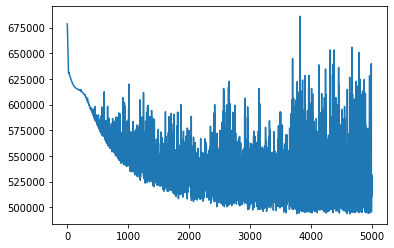

In [6]:
num_epochs=5000
verbose=True
sess = tf.Session()
optimizer = tf.train.AdamOptimizer(0.01)
t = []
train = optimizer.minimize(-pacelbo)
init = tf.global_variables_initializer()
sess.run(init)

for i in range(num_epochs+1):
    t.append(-sess.run(pacelbo))
    sess.run(train)
    if verbose:
        if i % 10 == 0: print(".", end="", flush=True)
        if i % 100 == 0:
            str_elbo = str(-t[-1])
            print("\n" + str(i) + " epochs\t" + str_elbo, end="", flush=True)

plt.plot(t)

## Evaluating the learned model
Once the model is learned, we evaluate how it makes predictions by ploting its associated epistemic and aleatoric uncertainty

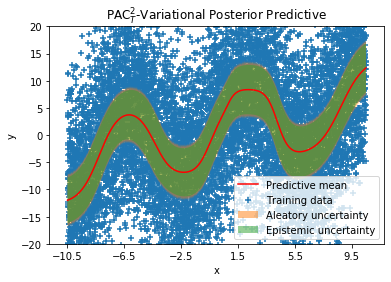

In [7]:
NSAMPLETEST = 10000
(x_test, y_test) = sampleData(NSAMPLETEST, VAR)


with ed.interception(ed.make_value_setter(W=qW,b=qb,W_out=qW_out,b_out=qb_out,x=x_test)):
    pW,pb,pW_out,pb_out,px,py = model(NHIDDEN,NSAMPLETEST)


y_pred_list = []
y_pred_noise = []

for i in range(100):
    [mean, noise] = sess.run([py.distribution.mean(), py])
    y_pred_list.append(mean)
    y_pred_noise.append(noise)

y_preds = np.concatenate(y_pred_list, axis=1)
y_preds_noise = np.concatenate(y_pred_noise, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

y_sigma_noise = np.std(y_preds_noise, axis=1)

plt.plot(x_test, y_mean, 'r-', label='Predictive mean');
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.fill_between(x_test.ravel(),
                 y_mean + 2 * y_sigma_noise,
                 y_mean - 2 * y_sigma_noise,
                 alpha=0.5, label='Aleatory uncertainty')

plt.fill_between(x_test.ravel(),
                 y_mean + 2 * y_sigma,
                 y_mean - 2 * y_sigma,
                 alpha=0.5, label='Epistemic uncertainty')


plt.ylabel('y')
plt.xlabel('x')

plt.ylim(-20,20)
plt.xticks(np.arange(-10.5, 10.5, 4))
plt.legend();

if LEARNING_METHOD==3:
    plt.title(r'PAC$^2_T$-Variational Posterior Predictive')
elif LEARNING_METHOD==2:
    plt.title(r'PAC$^2$-Variational Posterior Predictive')
elif LEARNING_METHOD==1:
    plt.title(r'Variational Posterior Predictive')
elif LEARNING_METHOD==0:
    plt.title(r'MAP Posterior Predictive')

plt.show()

We also compute the *log-likelihood of the predicitive posterior* over the independent test data set.

In [8]:
y_pred_list = []
for i in range(100):
    y_pred_list.append(sess.run(py.distribution.log_prob(y_test)))

y_preds = tf.concat(y_pred_list, axis=1)

score = tf.reduce_sum(tf.math.reduce_logsumexp(y_preds,axis=1)-tf.log(100.))

score = sess.run(score)/NSAMPLETEST

print("\nNegative Log-likelihood of the posterior predicitive: "+str(score))


Negative Log-likelihood of the posterior predicitive: -24.5454828125
